# Predicting house prices: a regression example
Another common type of machine learning probelm is *regression*, which consists of predicting a continuous value instead of a discrete label.

### 3.6.1 The Boston Housing Price dataset
We will work with a dataset with information gathered on Boston homes in the 1970s. This dataset only has 506 data points: 404 training and 102 test samples. Plus, each feature in the input data has a different scale: some fall between 0 and 1 while others range from 1 to 12.

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


40960/57026 [====================>.........] - ETA: 0s

In [2]:
# Let's look at the data
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

Each sample has 13 numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, etc. The target values are median values of owner-occupied homes, in thousands of dollars:

In [4]:
train_targets

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5,  10.9,  30.8,  32.9,  24. ,  18.5,  13.3,  22.9,
        34.7,  16.6,  17.5,  22.3,  16.1,  14.9,  23.1,  34.9,  25. ,
        13.9,  13.1,  20.4,  20. ,  15.2,  24.7,  22.2,  16.7,  12.7,
        15.6,  18.4,  21. ,  30.1,  15.1,  18.7,   9.6,  31.5,  24.8,
        19.1,  22. ,  14.5,  11. ,  32. ,  29.4,  20.3,  24.4,  14.6,
        19.5,  14.1,  14.3,  15.6,  10.5,   6.3,  19.3,  19.3,  13.4,
        36.4,  17.8,  13.5,  16.5,   8.3,  14.3,  16. ,  13.4,  28.6,
        43.5,  20.2,  22. ,  23. ,  20.7,  12.5,  48.5,  14.6,  13.4,
        23.7,  50. ,  21.7,  39.8,  38.7,  22.2,  34.9,  22.5,  31.1,
        28.7,  46. ,  41.7,  21. ,  26.6,  15. ,  24.4,  13.3,  21.2,
        11.7,  21.7,  19.4,  50. ,  22.8,  19.7,  24.7,  36.2,  14.2,
        18.9,  18.3,  20.6,  24.6,  18.2,   8.7,  44. ,  10.4,  13.2,
        21.2,  37. ,

The prices fall between \$10K and $50K, but this is the 1970s.

### 3.6.2 Preparing the data
It would be problematic to feed a neural network values that all take wildly different ranges. A best-practice to deal with such data is to do a feature-wise normalization: for each feature in the input data, you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in numpy.

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### 3.6.3 Building network
Because there are so few samples, we will build a very small network with two hidden layers, each with 64 units. In general, the less data you have, the worse overfitting will be, so one way to mitigate this is by using a small network.

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network ends with a single unit and no activation (linear layer), which is a typical setup for a scalar regression. Applying an activation function would constrain the range the output can take. Because the last layer is purely linear, the network is free to predict values in any range.

Note that the network is compiled with the mean squared error loss function, which is widely used for regression problems. We're also monitoring the mean absolute error metric, which is the absolute value of the difference between the predictions and the targets. An MAE of 0.5 would mean that our predictions are off by \$500 on average.

### 3.6.4 Validating approach using K-fold validation
To evaluate the network while adjusting its parameters (such as the number of epochs to use), we could split the data into a training set and a validation set, but because we have so few data points, the validation set would be really small.

Instead, a best practice is using *K-fold* cross-validation, which consists of splitting the available data into *K* partitions, instantiating *K* identical models, and training each one on *K - 1* partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the *K* validation scores obtained.

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [8]:
for i in range(k):
    print "processing fold #", i
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
all_scores

[2.0480517385029557,
 2.3514276070169884,
 2.8854849869661994,
 2.4051417159562063]

In [10]:
np.mean(all_scores)

2.4225265121105877

The different runs show rather different validation scores, from 2.0 to 2.8. The average (2.4) is a much more reliable metric than any single scores. Let's try training the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, we'll modify the training loop to save the per-epoch validation score log.

In [15]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print "processing fold #", i
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets), 
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
# compute average of the per-epoch MAE score for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

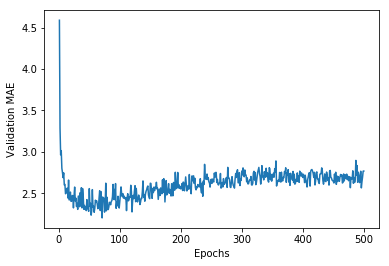

In [17]:
# plot MAE history
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Due to scaling issues and relatively high variance, it may be difficult to see the plot. Let's help this by omitting the first 10 data points and replacing each point with an exponential moving average of the previous points to obtain a smooth curve.

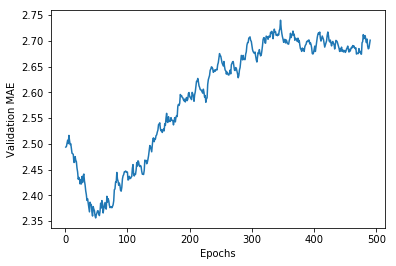

In [19]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. It starts overfitting after that point.

Let's train the final model:

In [20]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

 32/102 [========>.....................] - ETA: 0s

In [21]:
test_mae_score

3.2016644851834166

Still off by about \$3,200.